# 🧮 Effects of flow on molecular transport mechanisms
A very useful set of formulas approximating $\mathcal{Sh}$ relevant to many environmental particles is given by Kiorboe et al. (2001). Here is a plot of $\mathcal{Sh}$ as a function of $\mathcal{Re}$ and $\mathcal{Sc}$ for spherical particles:

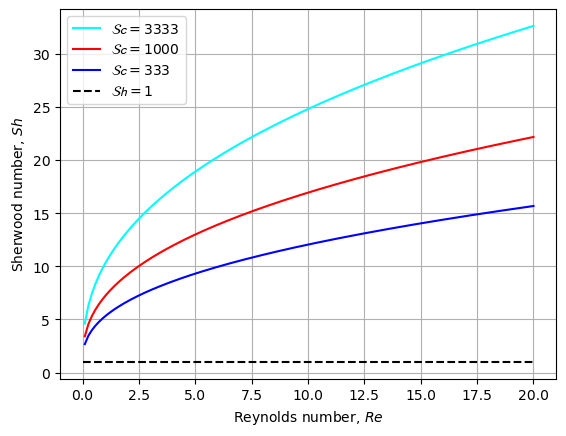

In [15]:
# Import modules:
#%matplotlib
from math import *
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import root, bisect
import matplotlib.pyplot as plt
plt.ion()
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Experimental data for Cd for a sphere:
relist=[ .05875, .1585, .4786, 3.020, 7.015, 15.49, 57.54, 144.5, 264.9, 512.9, 1000., 1862., 3162., 4764., 8375., .1556*10**5, .2648*10**5, .3467*10**5, .5888*10**5, .1000*10**6, .1702*10**6, .2317*10**6, .2648*10**6, .2710*10**6, .2851*10**6, .3020*10**6, .3388*10**6, .3981*10**6, .5129*10**6, .1778*10**7, .2291*10**7, .5012*10**7]
cdlist = [492.0, 169.8, 58.88, 10.86, 5.623, 3.388, 1.479, .9204, .7194, .5623, .4786, .4365, .4074, .3890, .3981, .4395, .4571, .4775, .4732, .4624,.4395, .4046, .3733, .3467, .2472, .1778, .1047, .09772, .1000, .1778, .1862, .1862]
CdRe_logdata = [(log(relist[i],10),log(cdlist[i],10)) for i in range(len(relist))]
Re_logdata = [log(relist[i],10) for i in range(len(relist))]
Cd_logdata = [log(cdlist[i],10) for i in range(len(relist))]
stokes_transition = 1.5
#CdL_interp = spline(CdRe_logdata)
#CdL_interp = CubicSpline(Re_logdata,Cd_logdata)
CdL_interp = interp1d(Re_logdata,Cd_logdata)
ReL_plot = np.linspace(-4,Re_logdata[-1],num=128)
#ReL_plot = np.linspace(Re_logdata[0],Re_logdata[-1],num=128)
#CdL_plot = CdL_interp(ReL_plot)
# Stokes and Oseen analytical solutions
Cd_Stokes = lambda Re_: 24./Re_
Cd_Oseen = lambda Re_: 24./Re_*(1.+3./16.*Re_)
CdL_Stokes = lambda logRe_: np.log10(24./np.power(10,logRe_))
CdL_Oseen = lambda logRe_: np.log10(24./np.power(10,logRe_)*(1.+3./16.*np.power(10,logRe_)))
CdRe = lambda logRe_: CdL_Oseen(logRe_) if logRe_ <= log(stokes_transition,10) else CdL_interp(logRe_)
CdL_plot = [CdRe(r) for r in ReL_plot]

def cd_error(r,F_D,rho,mu,U):
    """A function evaluating the error between the parameter U and the
    movement speed of a sphere with radius r subjected to force F_D in
    fluid with density rho and viscosity mu. The U for which this function
    evaluates to zero is the steady state movement speed. """
    if U==0.:
        return -F_D
    else:
        signU=np.sign(U)
        absU=abs(U)
        #print 'got here...',r,F_D,rho,mu,U
        logRe=log(2.*rho*r*absU/mu,10)
        logCd=CdRe(logRe)
        return (signU*0.5*rho*pi*r**2*U**2)*10**logCd - F_D

def U_sphere(r,F_D,rho,mu):
    """Steady-state movement velocity of a sphere in fluid, as determined by the
    root of the error metric cd_error. 
    """
    # Determine the range over which the numerical root-finding algorithm should operate:
    #Re_=2*rho*r*U./mu
    Urange=relist[-1]*mu/(2.*rho*r)
    Uerr = lambda u: cd_error(r,F_D,rho,mu,u)
    U=bisect(Uerr,-Urange,Urange, rtol=0.000001,full_output=False)
    return U


def Sherwood(r,D,rho,mu,U):
    """ Calculate the Sherwood number for a moving sphere according to the curve fit from
    Kiorboe et al. (2001). D is the diffusion coefficient; other parameters as above."""
    Re_=r*U*rho/mu  # Note that Kiorboe et al. use radius, not diameter as the length scale for Re
    Pe_=r*U/D  # Note that Kiorboe et al. use radius, not diameter as the length scale for Re
    Sc=mu/(D*rho)
    #Sc=Pe_/Re_
    Sh = 1. + 0.62 * Re_**0.41 * Sc**(1/3)
    return Sh


Sh_RePe = lambda Re_,Pe_: Sherwood(1,Pe_**(-1),1,Re_**(-1),1)   
Sh_RePe3333 = lambda Re_: Sherwood(1,3333.**(-1),1,Re_**(-1),1)   
Sh_RePe1000 = lambda Re_: Sherwood(1,1000.**(-1),1,Re_**(-1),1)   
Sh_RePe333 = lambda Re_: Sherwood(1,333.**(-1),1,Re_**(-1),1)   
Sh_ReSc = lambda Re_,Sc_: Sherwood(1,1./(Sc_*Re_),1.,1./Re_,1.)   
Sh_ReSc3333 = lambda Re_: Sherwood(1.,1./(3333.*Re_),1.,1./Re_,1.)   
Sh_ReSc1000 = lambda Re_: Sherwood(1,1./(1000.*Re_),1.,1/Re_,1.)   
Sh_ReSc333 = lambda Re_: Sherwood(1,1./(333.*Re_),1.,1./Re_,1.)   

# Show the Sherwood plots 
fig2, ax2 = plt.subplots()
Re_Sher = np.linspace(1.e-1,2.e1,num=128)
ax2.plot(Re_Sher,Sh_ReSc3333(Re_Sher),color='cyan',label=r'$\mathcal{Sc}=3333$')
ax2.plot(Re_Sher,Sh_ReSc1000(Re_Sher),color='red',label=r'$\mathcal{Sc}=1000$')
ax2.plot(Re_Sher,Sh_ReSc333(Re_Sher),color='blue',label=r'$\mathcal{Sc}=333$')
ax2.plot([0,Re_Sher.max()],[1,1],color='k',linestyle='--',label=r'$\mathcal{Sh}=1$')
ax2.set_xlabel(r'Reynolds number, $Re$')
ax2.set_ylabel(r'Sherwood number, $Sh$')
ax2.grid()
ax2.legend();

In this plot, the cyan, red and blue lines represent the Sherwood number, $\mathcal{Sh}$, for different Schmidt numbers, $\mathcal{Sc}$. 
$\mathcal{Sc}$is the ratio of the fluid kinematic viscosity to the solute's diffusion coefficient.
That is, higher $\mathcal{Sc}$ implies more viscous fluids or less diffusive solutes.
Conversely, lower $\mathcal{Sc}$ implies less viscous fluids or more diffusive solutes.

The dashed black line represents $\mathcal{Sh}=1$; that is, the case when flow has no effect on mass flux.

## Sherwood number calculator
As you can see in the plot above, under some conditions mass transport is greatly increased by fluid flow. 
But, under other conditions, the increase is minimal. 
Which applies to a given situation?</p>

The text panel below enables you to enter the particle size, density and surface solute concentration, and the fluid viscosity, density and solute concentration. 
The worksheet will then calculate for you the corresponding $\mathcal{Re}$, $\mathcal{Sh}$ and mass transport rates.

In many environmental problems, important issues involve the amount of mass transport per unit mass of particle. 
For example, a pollution problem may involve knowing whether a given mass of pollutant divided into many small particles has a different environmental effect than the same mass in a few larger particles. 
In the example of nutrient uptake by phytoplankton, an ecological question might revolve around whether a given biomass of small cells is more effective at competing for nutrients than an equal biomass of large cells. 
The calculator enables you to address those questions by calculating the mass transport per unit mass of particle.

In [16]:
mu7=widgets.FloatText(value=1.376e-3,width=20,description = r"$\mu~~ (\frac{N s}{m^2})$")
rho_water=widgets.FloatText(value=1028.,description = r"$\rho~~ (\frac{kg}{m^3})$")
rho_sphere=widgets.FloatText(value=1105.,description = r"$\rho_{sphere}~~ (\frac{kg}{m^3})$")
C_s=widgets.FloatText(value=0.,description = r"$C_s$")
C_w=widgets.FloatText(value=1.,description = r"$C_w$")
D7=widgets.FloatText(value=5.e-6,description = r"$D~~ (m)$")
K7=widgets.FloatText(value=0.001,description = r"$K~~ (\frac{m^2}{s})$")

ui1e = widgets.VBox([mu7,rho_water,C_w])
ui2e = widgets.VBox([rho_sphere,D7,C_s])
ui3e = widgets.HBox([ui1e, ui2e])

def Sh7(rho_water,rho_sphere,D7,mu7,K7,C_w,C_s):
    rr=D7/2.
    vol=float(4./3.*pi*rr**3)
    excess_mass=-(rho_sphere-rho_water)*vol # Keep the same sign convention as 
                                            # Het_labX.sws -- positive z is up
    g=9.81
    ff=g*excess_mass
    if rho_water==rho_sphere:
        print('External force is zero...')
        U_s=0.
    else:
        U_s=U_sphere(rr,ff,rho_water,mu7)
    print('Volume = {:.4g}'.format(vol))
    print('Excess mass = {:.4g}'.format(excess_mass))
    print('Gravity/buoyancy force = {:.4g}'.format(g*excess_mass))
    print('Reynolds number: Re = {:.4g}'.format(2.*rr*abs(U_s)*rho_water/mu7))
    print('U = {:.4g}'.format(U_s))

    Flux_diff= float(4 * pi * K7 * rr * (C_w-C_s))
    #print '\nFlux_diff=',Flux_diff
    Sh = Sherwood(rr,K7,rho_water,mu7,abs(U_s))
    Flux_adv=float(Sh*Flux_diff)
    print('\nSherwood number: Sh = {}'.format(Sh))
    print('Diffusive transport: Q_diff = {}'.format(Flux_diff))
    print('Advective transport: Q_adv = {}'.format(Flux_adv))
    
    print('\nAdvective transport per unit mass: Q_adv/Excess mass = {}'.format(Flux_adv/abs(excess_mass)))   
    
    
out7 = widgets.interactive_output(Sh7,{'rho_water':rho_water,'rho_sphere':rho_sphere,
                                      'D7':D7,'mu7':mu7,'K7':K7,'C_s':C_s,'C_w':C_w})
display(ui3e,out7)

Output()

:::{figure} #rs3_1
:placeholder: Images/RS3_1.png
:::